## 회귀 실습 - Bike Sharing Demand

2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자젼거 대여 횟수 기재됨

- datetime: hourly date + timestamp
- season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
- workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
- weather:
    - 1 = 맑음, 약간 구름 낀 흐림
    - 2 = 안개, 안개 + 흐림
    - 3 = 가벼운 눈, 가벼운 비 + 천둥
    - 4 = 심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않는 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

### 데이터 클렌징 및 가공

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
#문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [5]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
#mean_squared_log_error()를 이용해 구현할 경우 오버플로나 언더플로 오류가 발생하기 쉬움
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_square_error를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

#MSE, RMSE, RMSLE 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    #MAE는 사이킷런의 mean_absolute_error로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [7]:
#결과 값이 정규분포로 되어있는지 확인 & 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [8]:
def get_top_error_data(y_test, pred, n_tops=5):
    #DataFrame의 칼럼으로 실제 대여 횟수와 예측 값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    #예측 값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
#실제 값과 예측 값이 어느정도 차이 나는지 가장 큰 순 5개만 확인
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

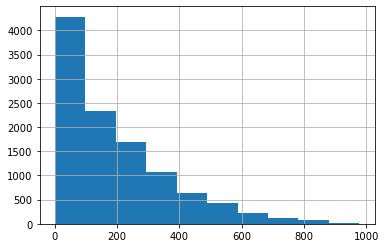

In [9]:
#큰 예측 오류가 발생할 경우 target 값의 분포가 왜곡된 형태를 이루는지 확인
y_target.hist()

<AxesSubplot:>

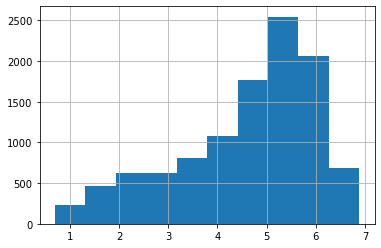

In [10]:
#왜곡되어 있으므로 정규 분포 형태로 바꿔줘야함 --> 로그 변환
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [11]:
#타깃 칼럼인 count값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#테스트 데이터 세트의 Target값은 로그 변환 되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

#예측 값 역시 로그 변환된 타깃 기반으로 학습 돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

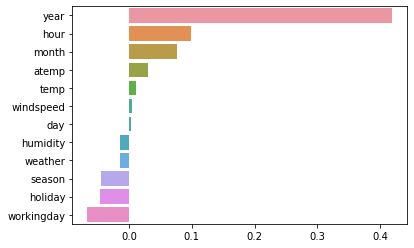

In [12]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [19]:
# year 피처의 회귀 계수 값이 독보적으로 큰 값 가짐
# year 피처는 연도이므로 카테고리형 피처지만 숫자형 값인 2011, 2012 로 되어있음 --> 회귀 계수 계산할 때 이 숫자형 값에 크게 영향 받음
# --> 원-핫 인코딩을 적용해 변환해야함

#'year', 'month', 'day', 'hour' 등의 피처를 one-hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [21]:
#원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치 반환 메소드
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

#모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.690, MAE: 63.383
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<AxesSubplot:>

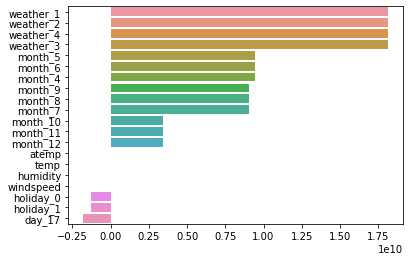

In [22]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    #XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능, ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.635, MAE: 31.346
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.338, MAE: 32.739
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
